In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
from google.colab import drive
from google.colab import files
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.utils.syspathcontext import prepended_to_syspath
from scipy import stats

from numpy.random import seed
import pickle
seed(1)
tf.random.set_seed(1)

In [ ]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = "/content/drive/Shareddrives/[Deep Learning Project]"
dataset_dir = os.path.join(root_path, "Dataset")
balanced_train_dir = os.path.join(dataset_dir, 'balanced_train') # We're using the balanced dataset
test_dir = os.path.join(dataset_dir, 'balanced_test')

In [ ]:
#Set the parameter used to load the dataset
BATCH_SIZE = 64
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

#Creation of the training, validation and test set

We exploit the directory hierarchy of our dataset to infer the classes from the
name of the directories, more details are present in the report about the choices taken.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    balanced_train_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="training",
    shuffle=True,
    seed=1024)

validation_dataset = image_dataset_from_directory(
    balanced_train_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="validation",
    shuffle=True,
    seed=1024)

test_dataset = image_dataset_from_directory(
    test_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 8100 files belonging to 18 classes.
Using 7290 files for training.
Found 8100 files belonging to 18 classes.
Using 810 files for validation.
Found 1474 files belonging to 18 classes.


In [ ]:
dir_name = os.path.join(root_path, "Models")
if not os.path.exists(dir_name):
  os.makedirs(dir_name)

In [ ]:
class_names = test_dataset.class_names

Choosing the models for the ensamble:

In [ ]:
vgg16filepath=os.path.join(dir_name, 'VGG16_fine_tuning.h5')
resnetfilepath=os.path.join(dir_name, 'resnet_fine_tuning.h5')
xceptionfilepath=os.path.join(dir_name, 'xception_fine_tuning2.h5')
inceptionfilepath=os.path.join(dir_name, 'InceptionV3_fine_tuning_2.h5')

vgg16model=keras.models.load_model(vgg16filepath)
resnetmodel=keras.models.load_model(resnetfilepath)
xceptionmodel=keras.models.load_model(xceptionfilepath)
inceptionmodel=keras.models.load_model(inceptionfilepath)

# models=[resnetmodel]
models=[vgg16model,resnetmodel,xceptionmodel,inceptionmodel]

Define a function to plot the Confusion Matrix:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(rounded_labels, predicted_labels, title):
  cm = confusion_matrix(rounded_labels, predicted_labels)
  fig = plt.figure(figsize = (9,8))
  ax1 = fig.add_subplot(1,1,1)
  ax1.set_title(title)
  sns.set(font_scale=1.1) #for label size
  sns.heatmap(cm, annot=True, annot_kws={"size": 10},cbar = True, cmap='Purples', fmt="d");
  ax1.set_ylabel('True Values',fontsize=14)
  ax1.set_xlabel('Predicted Values',fontsize=14)

  plt.show()

Function to print a table with the accuracies per class:

In [ ]:
def print_perc_table(class_names, rounded_labels, predicted_labels):

  counter_correct=[0 for i in range(18)]
  counter_errors=[0 for i in range(18)]
  counter_tot=[0 for i in range(18)]
  perc=[0 for i in range(18)]
  perc_number=[0 for i in range(18)]

  for count in range(len(rounded_labels)):
    if rounded_labels[count]==predicted_labels[count]:
      counter_correct[rounded_labels[count]]+=1
    else:
      counter_errors[rounded_labels[count]]+=1

  for i in range(18):
    counter_tot[i]=counter_correct[i]+counter_errors[i]
    perc[i]="{:.2f}".format(counter_correct[i]/counter_tot[i])
    perc_number[i]=counter_correct[i]/counter_tot[i]

  print("Average accuracy: {:.2f}\n".format(sum(perc_number)/len(perc_number)))

  data = np.array([np.array(class_names),np.array(perc)])
  return pd.DataFrame( perc,
    index=class_names,
    columns=["Accuracy"])

# Average Ensamble Model

Let's define now the fucntion that ensamble the predicitons of the individal models in this way:
* the final predicted class corrispond to the one with the maximum percentage of the sum of the individual prediction percentages
* this class will be the same as using the the average of the individual prediction percentages

In [ ]:
def ensamble_avg_predict(models):

  y_preds_models=[None]*len(models)
  preds_models=[None]*len(models)

  y_true = []  # store true labels
  y_pred = []  # store ensamble predicted labels
  # iterate over the dataset
  for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)

    # compute predictions
    for i in range(len(models)):
      preds_models[i]=models[i].predict(image_batch)

    # compute sum of predicted labels of the models
    preds = np.array(list(map(sum, zip(*preds_models))))

    # append predicted labels of the ensamble model
    y_pred.append(np.argmax(preds, axis = - 1))



  # convert the true and predicted labels into tensors
  correct_labels = tf.concat([item for item in y_true], axis = 0)
  predicted_labels = tf.concat([item for item in y_pred], axis = 0)


  return correct_labels, predicted_labels

In [ ]:
correct_labels_avg_ensamble, predicted_labels_avg_ensamble=ensamble_avg_predict(models)

1/1 [==============================] - 1s 1s/step


In [ ]:
rounded_labels_avg_ensamble=np.argmax(correct_labels_avg_ensamble, axis=1)

In [ ]:
print_perc_table(class_names, rounded_labels_avg_ensamble, predicted_labels_avg_ensamble)

Average accuracy: 0.74



,Accuracy
Albrecht Dürer,0.95
Alfred Sisley,0.92
Amedeo Modigliani,0.90
Andy Warhol,0.81
Edgar Degas,0.90
Francisco Goya,0.71
Henri Matisse,0.53
Marc Chagall,0.67
Mikhail Vrubel,0.34
Pablo Picasso,0.83


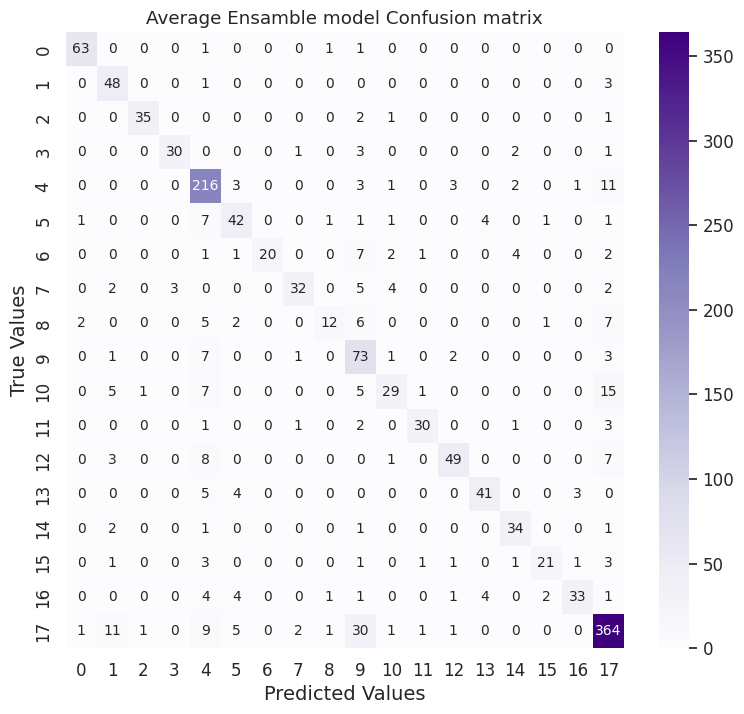

In [ ]:
plot_confusion_matrix(rounded_labels_avg_ensamble,predicted_labels_avg_ensamble,"Average Ensamble model Confusion matrix")

# Majority Vote Ensamble Model

Let's define now the function that esambles the predictions of the individual models selecting as the final predicted class the one most common in the individual predictions:

In [ ]:
def ensamble_mode_predict(models):
  
  y_preds_models=[None]*len(models)
  preds_models=[None]*len(models)
  batch_preds=[None]*len(models)

  y_true = []  # store true labels
  y_pred = []  # store ensamble predicted labels

  # iterate over the dataset
  for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)

    # compute predictions
    for i in range(len(models)):
      preds_models[i] = models[i].predict(image_batch)
      batch_preds[i] = np.argmax(preds_models[i], axis = - 1)

    # compute the mode of the predictions
    m = stats.mode(batch_preds, keepdims=True)
    mode_preds= m[0][0]
    # counts = m[1][0]

    # append predicted labels of the ensamble model
    y_pred.append(mode_preds)

  # convert the true and predicted labels into tensors
  correct_labels = tf.concat([item for item in y_true], axis = 0)
  predicted_labels = tf.concat([item for item in y_pred], axis = 0)


  return correct_labels, predicted_labels

In [ ]:
correct_labels_mode_ensamble, predicted_labels_mode_ensamble=ensamble_mode_predict(models)

1/1 [==============================] - 0s 27ms/step


In [ ]:
rounded_labels_mode_ensamble=np.argmax(correct_labels_mode_ensamble, axis=1)
print_perc_table(class_names, rounded_labels_mode_ensamble, predicted_labels_mode_ensamble)

Average accuracy: 0.71



,Accuracy
Albrecht Dürer,0.97
Alfred Sisley,0.92
Amedeo Modigliani,0.87
Andy Warhol,0.78
Edgar Degas,0.88
Francisco Goya,0.75
Henri Matisse,0.55
Marc Chagall,0.65
Mikhail Vrubel,0.29
Pablo Picasso,0.78


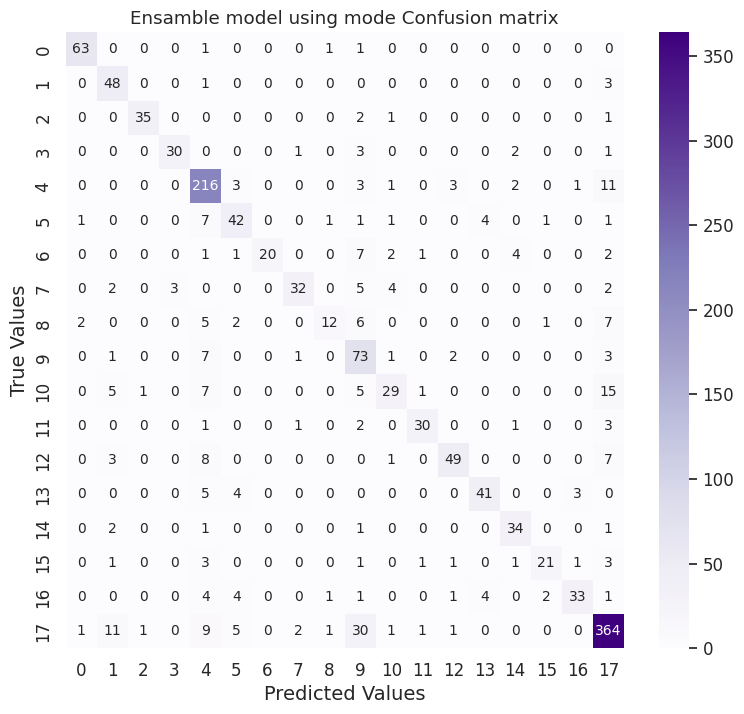

In [ ]:
plot_confusion_matrix(rounded_labels_avg_ensamble,predicted_labels_avg_ensamble,"Ensamble model using mode Confusion matrix")